## Camera API Test
- Probably it makes sense to write a camera interface class for each camera manufactuerer so things are modular (as in `stytra/hardware/video/cameras/interface.py`)
- For now, lets's just implement whatever at the hand, implement other things later if needed
- Probably different cameras are sold in Japan?

## Spinnaker
- Download Spinnaker from here: https://www.teledynevisionsolutions.com/products/spinnaker-sdk/
    - Install Spinnaker first 
    - Install PySpin from the downloaded .whl file using pip (make sure that the SDK itself and pyspin versions match)
- Follow the instruction in README.md

In [6]:
import numpy as np
import PySpin
from matplotlib import pyplot as plt

### Camera initialization

In [61]:
# access 'system' (whatever that is), and get the camera
system = PySpin.System.GetInstance()
camera = system.GetCameras()[0]

In [62]:
camera.Init() # initialization
nodemap = camera.GetNodeMap() # this is like a table (map) of the memory addresses of the camera which we want to read write

### Acquisition settings
- For camera control in general, we need to get the "node", which is like the memory address controlling specific aspects of the camera behavior, and write values there.
- In practice I have never set these parameters from stytra, and instead was doing it from Spinnaker GUI.
- Still it would make sense to read and display values?
#### Continuous mode

In [63]:
# get the node (like address?) that controls the acquisition mode
node_acqmode = PySpin.CEnumerationPtr(nodemap.GetNode("AcquisitionMode"))

# check if such a thing exists, or is writable (do we need this? when would this fail?)
if not PySpin.IsAvailable(node_acqmode) or not PySpin.IsWritable(node_acqmode):
    print('Acquisition Mode Node is either not available or writable')

In [64]:
# Now look at the nodemap again to find what do we need to write in the acquisition mode node to make it continuous
node_contmode = node_acqmode.GetEntryByName('Continuous')

# check if such a thing exists, or is readable (do we need this? when would this fail?)
if not PySpin.IsAvailable(node_contmode) or not PySpin.IsReadable(node_contmode):
    print('Somehting wrong with continous acquisition mode node')

In [65]:
# Finally write the damn thing
int_val_for_contmode = node_contmode.GetValue()
node_acqmode.SetIntValue(int_val_for_contmode)

#### ROI setting
- Maybe jut leave this to GUI?
- Use `SetValue()` methods if we want to do this programatically
- Note that offset depends on the size

In [66]:
# get nodes for ROI coordinates
roi_node_names = ['Width', 'Height', 'OffsetX', 'OffsetY']
roi_nodes = [PySpin.CIntegerPtr(nodemap.GetNode(rnn)) for rnn in roi_node_names]

In [67]:
for rnn, rn in zip(roi_node_names, roi_nodes):
    print(rnn, 'current value', rn.GetValue(), 'increment', rn.GetInc(), 'min', rn.GetMin(), 'max', rn.GetMax())

Width current value 400 increment 16 min 16 max 896
Height current value 358 increment 2 min 2 max 686
OffsetX current value 420 increment 4 min 0 max 928
OffsetY current value 362 increment 2 min 0 max 690


#### Frame control
- Again this could be left for the SpinView GUI

In [68]:
# frame rate node
node_acqrate = camera.AcquisitionFrameRate

In [69]:
# disable auto framerate update
# there are apparently different versions of cameras with different controls
node_acqfrenable = nodemap.GetNode("AcquisitionFrameRateEnable")

if PySpin.IsAvailable(node_acqfrenable):
    print('Disable auto framerate through enable node')
    node_acqfrenable.SetValue(True)
else:
    print('Disable auto framerate through auto node')
    node_acqfrauto = PySpin.CEnumerationPtr(nodemap.GetNode("AcquisitionFrameRateAuto"))
    node_frautooff = node_acqfrauto.GetEntryByName("Off")
    int_val_for_frautooff = node_frautooff.GetValue()
    node_acqfrauto.SetIntValue(int_val_for_frautooff)

    # enable rate mode
    node_ratemode = PySpin.CBooleanPtr(nodemap.GetNode("AcquisitionFrameRateEnabled"))
    node_ratemode.SetValue(True) # abbreviating writability checks etc

Disable auto framerate through auto node


In [70]:
print('Current frame rate:', node_acqrate.GetValue())
print('Max frame rate:', node_acqrate.GetMax())
print('Min frame rate:', node_acqrate.GetMin())

Current frame rate: 120.62136840820312
Max frame rate: 120.62136840820312
Min frame rate: 2.0


#### Exposure control
- This could be actually something that is on the software, as this might depend on the sample

In [71]:
node_expauto = camera.ExposureAuto
node_expauto.SetValue(PySpin.ExposureAuto_Off)

node_exptime = camera.ExposureTime
if node_exptime.GetAccessMode() == PySpin.RW:
    print('Exposure time is readable & writable on this camera')

Exposure time is readable & writable on this camera


In [72]:
print('Current exposure:', node_exptime.GetValue())
print('Max exposure:', node_exptime.GetMax())
print('Min exposure:', node_exptime.GetMin())

Current exposure: 6096.839904785156
Max exposure: 8284.62839126587
Min exposure: 7.62939453125


#### Gain control
- This is another thing I haven't really touched

In [73]:
node_gainauto = camera.GainAuto
node_gainauto.SetValue(PySpin.GainAuto_Off)

In [74]:
node_gain = camera.Gain
print('Current gain:', node_gain.GetValue())
print('Max gain:', node_gain.GetMax())
print('Min gain:', node_gain.GetMin())

Current gain: 9.550862312316895
Max gain: 18.061790466308594
Min gain: 0.0


### Acquisition

In [75]:
# begin acquisition
camera.BeginAcquisition()

In [76]:
fetched_image = camera.GetNextImage()

In [77]:
if not fetched_image.IsIncomplete():
    converted_image = np.array(fetched_image.GetData(), dtype='uint8').reshape((fetched_image.GetHeight(), fetched_image.GetWidth()))
    fetched_image.Release()

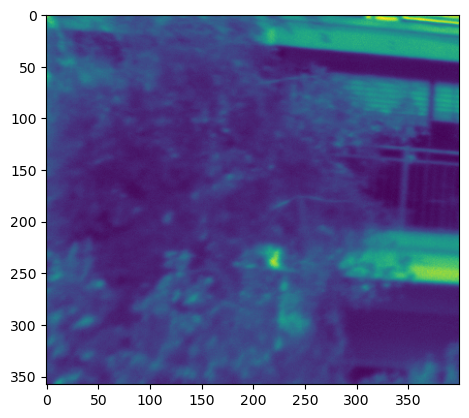

In [78]:
plt.imshow(converted_image)

### Closing

In [79]:
camera.EndAcquisition()
camera.DeInit()
system.ReleaseInstance()